In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import basedosdados as bd

C:\Users\Lord-\miniconda3\envs\ds-general\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import scipy

In [32]:
my_project_id = '######' #cadastrar um billing id no base dos dados: https://basedosdados.org/

In [ ]:
dic_rais = bd.read_sql(
    query = """SELECT *
                  FROM `basedosdados.br_me_rais.dicionario`
                  """,
                  billing_project_id=my_project_id)

In [7]:
dic_rais['nome_coluna'].unique()

array(['sexo', 'raca_cor', 'bairros_rj', 'bairros_sp', 'distritos_sp',
       'faixa_etaria', 'tipo_salario', 'tipo_vinculo', 'nacionalidade',
       'subsetor_ibge', 'tipo_admissao', 'tipo_deficiencia',
       'bairros_fortaleza', 'indicador_simples', 'subatividade_ibge',
       'vinculo_ativo_3112', 'faixa_tempo_emprego', 'motivo_desligamento',
       'causa_desligamento_1', 'causa_desligamento_2',
       'causa_desligamento_3', 'tipo_estabelecimento',
       'faixa_horas_contratadas', 'indicador_cei_vinculado',
       'tamanho_estabelecimento', 'grau_instrucao_1985_2005',
       'grau_instrucao_apos_2005', 'natureza_estabelecimento',
       'faixa_remuneracao_media_sm', 'indicador_trabalho_parcial',
       'regioes_administrativas_df', 'faixa_remuneracao_dezembro_sm',
       'indicador_portador_deficiencia',
       'indicador_trabalho_intermitente'], dtype=object)

In [8]:
tab_grau_instrucao = dic_rais[dic_rais['nome_coluna'] == 'grau_instrucao_apos_2005']

In [9]:
tab_grau_instrucao.head(1)

,id_tabela,nome_coluna,chave,cobertura_temporal,valor
5273,microdados_vinculos,grau_instrucao_apos_2005,9,2005(1),SUP. COMP


In [10]:
df = bd.read_sql(
          query = """WITH
        data_cte AS (
          SELECT
            grau_instrucao_apos_2005,
            valor_remuneracao_dezembro,
            NTILE(4) OVER (PARTITION BY grau_instrucao_apos_2005 ORDER BY valor_remuneracao_dezembro) AS quartile
          FROM
            basedosdados.br_me_rais.microdados_vinculos
          WHERE valor_remuneracao_dezembro >= 1200
            AND vinculo_ativo_3112 = 1
            AND ano = 2022
            AND quantidade_horas_contratadas >= 35
        ),
        quartiles AS (
          SELECT
            grau_instrucao_apos_2005,
            MIN(valor_remuneracao_dezembro) AS min_value,
            MAX(valor_remuneracao_dezembro) AS max_value,
            MAX(CASE WHEN quartile = 1 THEN valor_remuneracao_dezembro END) AS Q1,
            MAX(CASE WHEN quartile = 2 THEN valor_remuneracao_dezembro END) AS median,
            MAX(CASE WHEN quartile = 3 THEN valor_remuneracao_dezembro END) AS Q3
          FROM
            data_cte
          GROUP BY
            grau_instrucao_apos_2005
        ),
        iqr_calc AS (
          SELECT
            grau_instrucao_apos_2005,
            Q1,
            median,
            Q3,
            Q3 - Q1 AS IQR,
            MIN(min_value) AS min_value,
            MAX(max_value) AS max_value
          FROM
            quartiles
          GROUP BY
            grau_instrucao_apos_2005, Q1, median, Q3
        )
      SELECT
        grau_instrucao_apos_2005,
        min_value,
        Q1,
        median,
        Q3,
        max_value,
        IQR,
        Q1 - 1.5 * IQR AS lower_whisker,
        Q3 + 1.5 * IQR AS upper_whisker
      FROM
        iqr_calc;
                  """,
                                  billing_project_id=my_project_id)

Downloading: 100%|███████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.83rows/s]


In [14]:
df.head()

,grau_instrucao_apos_2005,min_value,Q1,median,Q3,max_value,IQR,lower_whisker,upper_whisker
0,8,1200.0,1894.00,2739.45,4528.54,181558.00,2634.54,-2057.810,8480.350
1,2,1200.0,1532.44,1967.32,2634.69,140000.00,1102.25,-120.935,4288.065
2,9,1200.0,3102.72,5375.62,9738.56,181809.79,6635.84,-6851.040,19692.320
3,7,1200.0,1600.72,2062.00,2959.76,181235.00,1359.04,-437.840,4998.320
4,3,1200.0,1600.00,2072.40,2848.00,170020.17,1248.00,-272.000,4720.000


In [17]:
df['grau_instrucao_apos_2005'].dtype, tab_grau_instrucao['chave'].dtype

(dtype('O'), dtype('int32'))

In [18]:
tab_grau_instrucao['chave'] = tab_grau_instrucao['chave'].astype(str)

In [19]:
df = df.merge(tab_grau_instrucao[['chave', 'valor']],
             how='left',
             left_on = 'grau_instrucao_apos_2005',
             right_on = 'chave')

In [20]:
df.rename(columns={'valor':'grau_instrucao'}, inplace=True)

In [21]:
df.head(3)

,grau_instrucao_apos_2005,min_value,Q1,median,Q3,max_value,IQR,lower_whisker,upper_whisker,chave,grau_instrucao
0,8,1200.0,1894.00,2739.45,4528.54,181558.00,2634.54,-2057.810,8480.350,8,SUP. INCOMP
1,2,1200.0,1532.44,1967.32,2634.69,140000.00,1102.25,-120.935,4288.065,2,ATE 5.A INC
2,9,1200.0,3102.72,5375.62,9738.56,181809.79,6635.84,-6851.040,19692.320,9,SUP. COMP


In [22]:
for a, b in [( 'ANALFABETO', 'Analfabeto'),
             (  'ATE 5.A INC', 'Até 5ª incompleto'),
             (  '5.A CO FUND', '5ª completo'),
             (  '6. A 9. FUND','6ª a 9ª incompleto'),
             (  'FUND COMPL', 'Fundamental completo'),
             (  'MEDIO INCOMP','Médio incompleto'),
             (  'MEDIO COMPL', 'Médio completo'),
             (  'SUP. INCOMP', 'Superior incompleto'),
             (  'SUP. COMP',  'Superior completo'),
             (  'MESTRADO', 'Mestrado'),
             (  'DOUTORADO', 'Doutorado')]:
    df['grau_instrucao'] = df['grau_instrucao'].str.replace(a, b)

In [23]:
df['grau_instrucao'] = pd.Categorical(df['grau_instrucao'], 
                                       categories=[ 
                                           'Analfabeto', 
                                           'Até 5ª incompleto',
                                           '5ª completo', 
                                           '6ª a 9ª incompleto',
                                           'Fundamental completo',
                                           'Médio incompleto',
                                           'Médio completo',
                                           'Superior incompleto',
                                           'Superior completo', 
                                           'Mestrado',
                                           'Doutorado'], 
                                       ordered=True)

In [24]:
df['lower_whisker'] = np.where(df['lower_whisker'] < df['min_value'], 
                               df['min_value'],
                               df['lower_whisker'])

In [25]:
def format_thousands(x, pos):
    return 'R$ {:,.0f}'.format(x).replace(',', '.')

In [26]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [29]:
#plt.style.use('seaborn')
plt.style.use('seaborn-v0_8-colorblind')

In [30]:
plt.rc('figure', figsize=(7,4), titlesize=15)
plt.rc('lines', linewidth=2)
plt.rc('axes', labelsize=8, titlesize=8, titleweight='bold', titley=1.05, labelpad=6) # vai mudar do x e do y
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=8)
plt.rc('legend', loc='lower center', fontsize=8, frameon=True, framealpha=0.8)

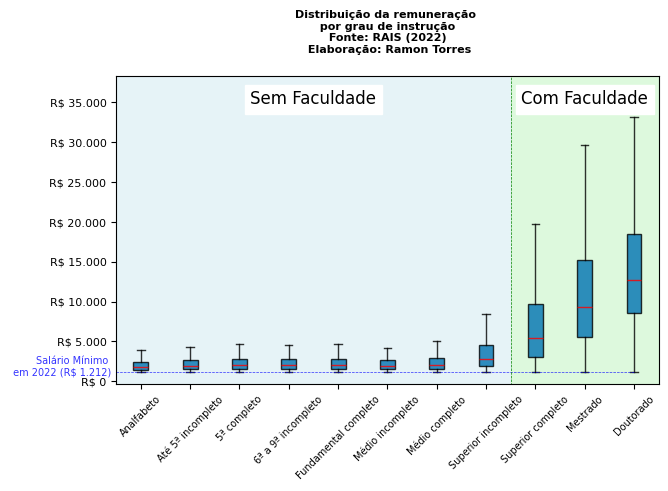

In [31]:
grau_instrucao_categories = df['grau_instrucao'].cat.categories
fig, ax = plt.subplots()
alpha=0.8
for i, cat in enumerate(grau_instrucao_categories):
    data = df[df['grau_instrucao'] == cat][
        ['lower_whisker', 'Q1', 'median', 'Q3', 'upper_whisker']].values[0]
    ax.boxplot(data, positions = [i], 
               patch_artist=True,
               widths= 0.3,
               boxprops=dict(color='black', alpha=alpha),
               whiskerprops=dict(color='black', alpha=alpha),
               capprops=dict(color='black', alpha=alpha),
               medianprops=dict(color='red', alpha=alpha))

ylim_inf = ax.get_ylim()[0]
ylim_sup = ax.get_ylim()[1]

y_value = 1212  # salário minimo
ax.hlines(y=y_value, xmin=-0.5, xmax=len(grau_instrucao_categories)-1, color='blue', linestyle='--', lw=0.5, alpha=alpha)

ax.text(-0.6, 1800, 'Salário Mínimo \n em 2022 (R$ 1.212)',
        va='center', ha='right', backgroundcolor='None', fontsize=7, color='blue',alpha=alpha)


x_value = 7.5
ax.axvline(x=x_value, color='green', linestyle='--', lw = 0.5, ymin = ylim_inf, ymax = ylim_sup)

ax.fill_between([-0.5, x_value],
                ylim_inf, 
                ylim_sup*1.1,
                facecolor='lightblue', alpha=0.3)
ax.fill_between([x_value, len(grau_instrucao_categories)-0.5], 
                ylim_inf,
                ylim_sup*1.1, 
                facecolor='lightgreen', alpha=0.3)

# caixinhas de texto
y_max = ylim_sup*1.05
left_label = 'Sem Faculdade'
right_label = 'Com Faculdade'
left_x_center = (x_value - (-0.5)) / 2 - 0.5
right_x_center = (len(grau_instrucao_categories)-0.5 + x_value) / 2 
ax.text(left_x_center, y_max, left_label, va='top', ha='center', fontsize=12, backgroundcolor='white')
ax.text(right_x_center, y_max, right_label, va='top', ha='center', fontsize=12, backgroundcolor='white')

ax.set_ylim(ylim_inf, ylim_sup*1.1)
ax.set_xticks(range(len(grau_instrucao_categories)))
ax.set_xticklabels(grau_instrucao_categories)
ax.xaxis.set_tick_params(rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(format_thousands))
ax.set_title('Distribuição da remuneração \n por grau de instrução \n Fonte: RAIS (2022) \n Elaboração: Ramon Torres', loc='center')
plt.show()

In [93]:
fig.savefig(fr"boxplot_salario_educacao_ramon_torres.png", 
            dpi=200,  bbox_inches="tight"
)